### Introduction

To warm up in PyTorch, we're making a pretty project with lots of batched linear operations: Triangle Rendering!

We'll actually start with doing a bit of rendering from 2d to 1d to simplify (instead of 3d to 2d). After that, we're going to render a binary 'is there a triangle at this pixel?' for one triangle, render all the triangles at once in a batch, and then combine them, and then more than just binary 'is there a triangle?'.


Here's our model of the world: the "camera" is a point with a grid of lines pointing out of it - each of these corresponds to one pixel in the camera's image. Out there are a bunch of triangles, each specified by three points. In order to find the color of each pixel, we'll check whether the line coming from the camera intersects with the area of any of the the triangles. Then we can color the pixel based on some information about that triangle that the line hit.

![image](https://www.scratchapixel.com/images/upload/rasterization/raytracing-raster.png?)

### Before we render 2d images, lets render 1d images

Here, instead of checking whether a 2d grid of rays intersects with triangles, we will check whether a 1d fan of rays intersects with lines.

We will use 3 dimensions, but the last dimension will always be 0 for now. Let's have our camera at (0,0,0), and its rays will be ((0,0,0), (1, -1, 0)), (0,0,0), (1, -0.9, 0)), ect.

Make the function
```
make_rays_1d(width_pixels: int, fov_ratio)
->
FloatTensor[width_pixels (number of rays), 2 (origin and direction), 3 (scalars per point)]
```
that creates rays going from the camera (origin) in each pixel direction. fov_ratio means "how far to the left/right can I see 1 unit away from the camera?". At fov_ratio=1, you can see 1-unit to the left at 1 unit away, and so on.

Once you think you've made it correctly, run the `render_lines_with_pyplot` function we provide on your rays tensor with 10 rays and an fov_ratio of 10. Note that you should convert from origin and direction to lines segments with start points and endpoints for `render_lines_with_pyplot`. It won't make any difference here because the origin is at (0, 0, 0), but it's good to be in habit of using the correct units/types. It should look like this: ![image.png](attachment:image.png).

In [ ]:
import torch as t
import einops
from mpl_toolkits.mplot3d.axes3d import Axes3D
import matplotlib.pyplot as plt
from ipywidgets import interact

def render_lines_with_pyplot(lines):
    fig, ax = plt.subplots(subplot_kw={'projection': '3d'})

    for line in lines:
        # dimension ordering is so ray fan displays nicely
        ax.plot(line[:,1].numpy(), line[:,0].numpy(), line[:,2].numpy())

    plt.show()

In [ ]:
import torch
torch.arange?

Docstring:
arange(start=0, end, step=1, *, out=None, dtype=None, layout=torch.strided, device=None, requires_grad=False) -> Tensor

Returns a 1-D tensor of size :math:`\left\lceil \frac{\text{end} - \text{start}}{\text{step}} \right\rceil`
with values from the interval ``[start, end)`` taken with common difference
:attr:`step` beginning from `start`.

Note that non-integer :attr:`step` is subject to floating point rounding errors when
comparing against :attr:`end`; to avoid inconsistency, we advise adding a small epsilon to :attr:`end`
in such cases.

.. math::
    \text{out}_{{i+1}} = \text{out}_{i} + \text{step}

Args:
    start (Number): the starting value for the set of points. Default: ``0``.
    end (Number): the ending value for the set of points
    step (Number): the gap between each pair of adjacent points. Default: ``1``.

Keyword args:
    out (Tensor, optional): the output tensor.
    dtype (:class:`torch.dtype`, optional): the desired data type of returned tensor.
       

In [ ]:
import torch
torch.zeros?

Docstring:
zeros(*size, *, out=None, dtype=None, layout=torch.strided, device=None, requires_grad=False) -> Tensor

Returns a tensor filled with the scalar value `0`, with the shape defined
by the variable argument :attr:`size`.

Args:
    size (int...): a sequence of integers defining the shape of the output tensor.
        Can be a variable number of arguments or a collection like a list or tuple.

Keyword args:
    out (Tensor, optional): the output tensor.
    dtype (:class:`torch.dtype`, optional): the desired data type of returned tensor.
        Default: if ``None``, uses a global default (see :func:`torch.set_default_tensor_type`).
    layout (:class:`torch.layout`, optional): the desired layout of returned Tensor.
        Default: ``torch.strided``.
    device (:class:`torch.device`, optional): the desired device of returned tensor.
        Default: if ``None``, uses the current device for the default tensor type
        (see :func:`torch.set_default_tensor_type`). :attr:`devi

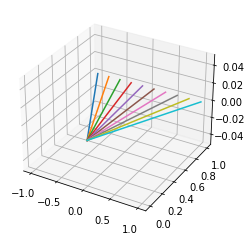

In [ ]:
def make_rays_1d(W, fov_ratio):
    offset = 2 * fov_ratio/(W-1)
    EPS = offset * 1e-6
    offsets = t.arange(start=-fov_ratio, end=fov_ratio + EPS, step=offset)
    lines = t.zeros(W, 2, 3)
    lines[:,1,0] = 1
    lines[:,1,1] = offsets
    return lines

render_lines_with_pyplot(make_rays_1d(10, 1))

    

### Now let's check whether our camera rays intersect with our object lines

This has two steps: find the point where the two (infinite euclidean) lines intersect by solving a linear equation, and then check whether that point is inside the line segment and the ray.


Our camera ray is defined by the origin $O$ and direction $D$ and our object line is defined by points $L_1$ and $L_2$.

We can write the equations for all points on the camera ray as $R(u)=O +u D$ for $u \in [0, \infty)$ and on the object line as $O(v)=L_1+v(L_2 - L_1)$ for $v \in [0, 1]$.

In [ ]:
@interact
def line(v=(-2.0, 2.0), seed=(0, 10)):
    t.manual_seed(seed)
    L_1 = t.randn(2)
    L_2 = t.randn(2)
    P = lambda v : L_1 + v * (L_2 - L_1)
    x, y = zip(P(-2), P(2))
    plt.plot(x, y, 'g-')
    plt.plot(*L_1, 'ro', markersize=12)
    plt.plot(*L_2, 'ro', markersize=12)
    plt.plot(P(v)[0], P(v)[1], '*', markersize=12)

interactive(children=(FloatSlider(value=0.0, description='v', max=2.0, min=-2.0), IntSlider(value=5, descripti…

Setting the line equations from above equal:

\begin{align}
O + u D &= L_1 + v(L_2 - L_1) \\
u D - v(L_2 - L_1) &= L_1 - O  \\
\begin{pmatrix}
D_x & (L_1 - L_2)_x \\
D_y & (L_1 - L_2)_y \\
\end{pmatrix}
\begin{pmatrix}
u \\
v \\
\end{pmatrix}
&= 
\begin{pmatrix}
(L_1 - O)_x \\
(L_1 - O)_y \\
\end{pmatrix}
\end{align}


Once we've found values of $u$ and $v$ which satisfy this equation (if any, the lines could be parallel) we just need to check that $u \geq 0$ and $v \in [0, 1]$.

Here are some objects:

In [ ]:
def get_objects(n, seed=8):
    t.manual_seed(seed)
    xys = t.rand(n, 2, 2)
    xys[:,:,1]-=0.5
    xys[:,:,1]*=10
    return t.cat([xys, t.zeros(n, 2, 1)], dim=2)

objects = get_objects(3)

objects.size()

torch.Size([3, 2, 3])

Render the camera lines from earlier together with the object lines using the `render_lines_with_pyplot`. This can be done in one line of code.

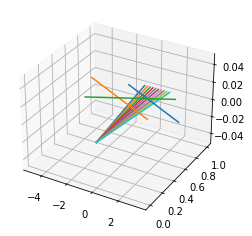

In [ ]:
lines = make_rays_1d(10, 1)
render_lines_with_pyplot(t.cat([lines, objects], dim=0))

In [ ]:
import torch
torch.linalg.solve?

Docstring:
linalg.solve(A, B, *, out=None) -> Tensor

Computes the solution of a square system of linear equations with a unique solution.

Letting :math:`\mathbb{K}` be :math:`\mathbb{R}` or :math:`\mathbb{C}`,
this function computes the solution :math:`X \in \mathbb{K}^{n \times k}` of the **linear system** associated to
:math:`A \in \mathbb{K}^{n \times n}, B \in \mathbb{K}^{m \times k}`, which is defined as

.. math:: AX = B

This system of linear equations has one solution if and only if :math:`A` is `invertible`_.
This function assumes that :math:`A` is invertible.

Supports inputs of float, double, cfloat and cdouble dtypes.
Also supports batches of matrices, and if the inputs are batches of matrices then
the output has the same batch dimensions.

Letting `*` be zero or more batch dimensions,

- If :attr:`A` has shape `(*, n, n)` and :attr:`B` has shape `(*, n)` (a batch of vectors) or shape
  `(*, n, k)` (a batch of matrices or "multiple right-hand sides"), this function return

Using `torch.linalg.solve` and `torch.stack`, write the function
```
intersect_ray_1d(ray, obj) -> bool
```
which returns true if the ray and object intersect.

Keep in mind that your code only needs to work when then the z-dim is 0 (you can also assume that rays and objects aren't parallel).

Sanity check your function on a few rays using the image you made above as a reference.

In [ ]:
def intersect_ray_1d(ray, obj):
    D = ray[1] - ray[0]
    # Get first column: D_x, D_y
    # ray[1] ... D_x,D_y,D_z
    first_col = D[:2]
    # Get second column 
    L1 = obj[0][:2]
    L2 = obj[1][:2]
    second_col = L1 - L2

    A = torch.stack([first_col, second_col], dim=1)
    O = ray[0][:2]
    B = L1 - O
    X = t.linalg.solve(A, B)
    u = X[0].item()
    v = X[1].item()
    return u >= 0 and 0 <= v <= 1

In [ ]:
ray = make_rays_1d(10, 1)[0]
intersect_ray_1d(ray, objects[0])

True


---

Our camera ray is defined by the origin $O$ and direction $D$ and our object line is defined by points $L_1$ and $L_2$.

\begin{align}
O + u D &= L_1 + v(L_2 - L_1) \\
u D - v(L_2 - L_1) &= L_1 - O  \\
\begin{pmatrix}
D_x & (L_1 - L_2)_x \\
D_y & (L_1 - L_2)_y \\
\end{pmatrix}
\begin{pmatrix}
u \\
v \\
\end{pmatrix}
&= 
\begin{pmatrix}
(L_1 - O)_x \\
(L_1 - O)_y \\
\end{pmatrix}
\end{align}


Once we've found values of $u$ and $v$ which satisfy this equation (if any, the lines could be parallel) we just need to check that $u \geq 0$ and $v \in [0, 1]$.

---

Now let's batch process rays and objects with the function 
```
intersect_rays_1d(rays, objs) -> BoolTensor[num rays]
```
Where the output is true if there is some object which intersects with that ray. You'll probably want to use `einops.repeat`. This should look very similar to the non-batch version. If you'd like, you can also modify your non-batch function to handle either case.

In [ ]:
print(lines)
print(einops.repeat(lines, 'num_rays b c -> (num_rays num_objs) b c', num_objs=2))

tensor([[[ 0.0000,  0.0000,  0.0000],
         [ 1.0000, -1.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000],
         [ 1.0000, -0.7778,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000],
         [ 1.0000, -0.5556,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000],
         [ 1.0000, -0.3333,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000],
         [ 1.0000, -0.1111,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000],
         [ 1.0000,  0.1111,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000],
         [ 1.0000,  0.3333,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000],
         [ 1.0000,  0.5556,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000],
         [ 1.0000,  0.7778,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000],
         [ 1.0000,  1.0000,  0.0000]]])
tensor([[[ 0.0000,  0.0000,  0.0000],
         [ 1.0000, -1.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000],
         [ 1.0000, -1.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000],
         [ 1.0000, -0.7778

tensor([True, True, True, True, True, True, True, True, True, True])


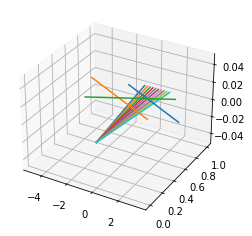

In [ ]:
def intersect_rays_1d(rays, objs):
    #D = ray[1] - ray[0]
    ## Get first column: D_x, D_y
    ## ray[1] ... D_x,D_y,D_z
    #first_col = D[:2]
    ## Get second column 
    #L1 = obj[0][:2]
    #L2 = obj[1][:2]
    #second_col = L1 - L2

    #A = torch.stack([first_col, second_col], dim=1)
    #O = ray[0][:2]
    #B = L1 - O
    #X = t.linalg.solve(A, B)
    #u = X[0].item()
    #v = X[1].item()
    #return u >= 0 and 0 <= v <= 1
    
    # For every object, duplicate the rays
    # Stack them all up
    # Duplicate objects and get what there is
    
    # rays: num_rays x 2 x 3
    # each ray: 2 x 3
    # want: num_rays x num_objs x 2 x 3 
    #
    # rays: 1 x num_rays x 2 x 3
    #    repeat the 0-th dimension num_objs times
    #    (num_rays * num_objs) x 2 x 3
    #
    # objs: num_objs x 2 x 3
    
    # LHS; duplicate rays
    # RHS: duplicate objects
    # Ray0, Obj0,
    # Ray0, Obj1, 
    # ...
    # Ray1, Obj0,
    # Ray1, Obj1,
    rays = rays[:,:,:2]
    objs = objs[:,:,:2]
    repeated_rays = einops.repeat(rays, 'num_rays b c -> (num_rays num_objs) b c', num_objs=len(objs))
    repeated_objs = einops.repeat(objs, 'num_objs b c -> (num_rays num_objs) b c', num_rays=len(rays))
    # rays: num_rays x 2 x 3
    D = repeated_rays[:,1,:] - repeated_rays[:,0,:]
    L1 = repeated_objs[:,0,:]
    L2 = repeated_objs[:,1,:]
    first_col = D
    second_col = L1 - L2
     
    # first_col is [first_col_ray0_obj0, first_col_ray0_obj1, ...]   (num_rays * num_objs) * 2
    # second_col is [second_col_ray0_obj0, second_col_ray0_obj1, ...] (num_rays * num_objs) * 2 
    # we want (num_rays * num_objs) * NEW_2 * 2 
    
    # single ray: 3, single obj: 3
    # dim=1
    # rays: k x 3, objs: k x 3
    # dim=2
    
    """
    x x2
    y y2
    z z2
    
    x 
    y
    z -> 3
    
    
    """
    
    # want: [torch.stack([first_col_ray0_obj0, second_col_ray0_obj0], dim=1), ...]
    # which means...
    A = torch.stack([first_col, second_col], dim=2)  # Stacking along last dimension to get two columns: (num_rays num_objs) * 2 * 2
    O = repeated_rays[:,0,:] # num_rays * 2
    B = L1 - O  # shape is same as O
    X = t.linalg.solve(A, B) # X should have same dims as B
    u = X[:, 0]
    v = X[:, 1]
    is_good_arr = t.logical_and(t.logical_and(u >= 0, 0 <= v), v <= 1)
    # (num_rays * num_objs) 
    is_good = einops.rearrange(is_good_arr, "(num_rays num_objs) -> num_rays num_objs", num_rays=rays.shape[0])
    results = torch.any(is_good, dim=1)
    # results = einops.reduce(is_good, "num_rays num_objs -> num_rays", torch.any)
    return results

rays = lines
objs = objects
print(intersect_rays_1d(rays, objs))
render_lines_with_pyplot(t.cat([rays, objs], dim=0))

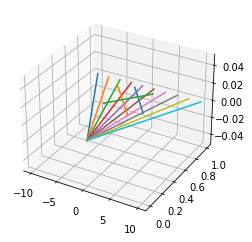

In [ ]:
lines = make_rays_1d(10, 10)
render_lines_with_pyplot(t.cat([lines, objects], dim=0))

In [ ]:
intersect_rays_1d(lines, objects)

tensor([False, False,  True,  True,  True,  True,  True,  True, False, False])

In [ ]:
objs

tensor([[[ 0.5979,  3.4530,  0.0000],
         [ 0.9464, -2.0347,  0.0000]],

        [[ 0.5138,  1.4435,  0.0000],
         [ 0.8991, -4.8591,  0.0000]],

        [[ 0.5785, -3.7819,  0.0000],
         [ 0.9181,  1.8053,  0.0000]]])

tensor([False])


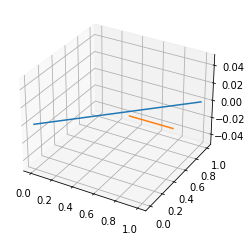

In [ ]:
# Intersects 0.5, 0.5
# 
# 0.5, 
rays = torch.Tensor([[[0,0,0], [1,1, 0]]])
objs = torch.Tensor([[[0,1,0], [1,0,0]]])  # Goes through 0,0,0
assert intersect_rays_1d(rays, objs)

rays = torch.Tensor([[[0,0,0], [1,1, 0]]])
objs = torch.Tensor([[[0.5,0.4,0], [0.5,1,0]]])  # Goes through 0,0,0
assert intersect_rays_1d(rays, objs)

# Should be False
rays = torch.Tensor([[[0,0,0], [1,1, 0]]])
objs = torch.Tensor([[[0.5,0.6,0], [0.5,1,0]]])  # Goes through 0,0,0
assert intersect_rays_1d(rays, objs) == False

print(intersect_rays_1d(rays, objs))
render_lines_with_pyplot(t.cat([rays, objs], dim=0))

In [ ]:
import einops
einops.repeat?

Signature: einops.repeat(tensor, pattern: str, **axes_lengths)
Docstring:
einops.repeat allows reordering elements and repeating them in arbitrary combinations.
This operation includes functionality of repeat, tile, broadcast functions.

Examples for repeat operation:

```python
# a grayscale image (of shape height x width)
>>> image = np.random.randn(30, 40)

# change it to RGB format by repeating in each channel
>>> repeat(image, 'h w -> h w c', c=3).shape
(30, 40, 3)

# repeat image 2 times along height (vertical axis)
>>> repeat(image, 'h w -> (repeat h) w', repeat=2).shape
(60, 40)

# repeat image 3 times along width
>>> repeat(image, 'h w -> h (repeat w)', repeat=3).shape
(30, 120)

# convert each pixel to a small square 2x2. Upsample image by 2x
>>> repeat(image, 'h w -> (h h2) (w w2)', h2=2, w2=2).shape
(60, 80)

# pixelate image first by downsampling by 2x, then upsampling
>>> downsampled = reduce(image, '(h h2) (w w2) -> h w', 'mean', h2=2, w2=2)
>>> repeat(downsampled, 'h w 

In [ ]:
# print(intersect_rays_1d(rays, objects))
# should be tensor([False, False,  True,  True,  True,  True,  True,  True, False, False])
# See your image with rays and objects above to check this makes sense.

### Now, lets generate a 2d grid of camera rays (back to 2d images)

Make a function

```
make_rays_2d(width_pixels: int, height_pixels: int, h_aspect_ratio = 0.3, w_aspect_ratio = 0.3)
->
FloatTensor[width_pixels * height_pixels (number of lines), 2 (origin and direction), 3 (scalars per point)]
```
that creates rays going from the camera (origin) in each pixel direction. h_aspect_ratio means "how wide of a thing that's 1 unit away can I see?". at h_aspect_ratio=1, you can see 1-unit-wide things that are 1 unit away, and so on.

Once you think you've made it correctly, run the `render_lines_with_pyplot` function we provide on your lines tensor. It should look like a bunch of evenly spaced lines in a pyramid.

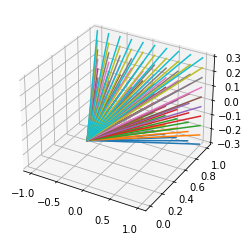

In [ ]:
# def make_rays_1d(W, fov_ratio):
#     offset = 2 * fov_ratio/(W-1)
#     EPS = offset * 1e-6
#     offsets = t.arange(start=-fov_ratio, end=fov_ratio + EPS, step=offset)
#     lines = t.zeros(W, 2, 3)
#     lines[:,1,0] = 1
#     lines[:,1,1] = offsets
#     return lines

# render_lines_with_pyplot(make_rays_1d(10, 1))

    
# 1D case: ((0,0,0), (1, -1, 0)), ((0,0,0), (1, -0.9, 0)), ...
# 2D case: also want to change z-axis

    
def make_rays_2d(W, H, width_scale=0.3, height_scale=0.3):
    width_offset = 2 * width_scale/(W-1)
    height_offset = 2 * height_scale/(H-1)
    
    width_EPS = width_offset * 1e-6
    height_EPS = height_offset * 1e-6
    
    width_offsets = t.arange(start=-width_scale, end=width_scale + width_EPS, step=width_offset)
    height_offsets = t.arange(start=-height_scale, end=height_scale + height_EPS, step=height_offset)
    
    # W, H, 2, 3
    # then reshape
    # repeated_rays = einops.repeat(rays, 'num_rays b c -> (num_rays num_objs) b c', num_objs=len(objs))
    # repeated_objs = einops.repeat(objs, 'num_objs b c -> (num_rays num_objs) b c', num_rays=len(rays))
    repeated_w_offsets = einops.repeat(width_offsets, 'W -> (W H)', H=H)
    repeated_h_offsets = einops.repeat(height_offsets, 'H -> (W H)', W=W)
    lines = t.zeros(W * H, 2, 3)
    lines[:,1,0] = 1
    lines[:,1,1] = repeated_w_offsets
    lines[:,1,2] = repeated_h_offsets
    return lines

render_lines_with_pyplot(make_rays_2d(10, 10, 1))

### Triangle coordinates

Analogously to a line, the area inside a triangle can be defined by three (non-colinear) points $A$, $B$ and $C$, and can be written algebraically as:

$$P(w, u, v) = wA + uB + vC$$
$$s.t.$$
$$0 \leq w,u,v$$
$$w + u + v = 1$$

Or equivalently:

$$P(u, v) = (1 - u - v)A + uB + vC =$$
$$P(u, v) = A + u(B - A) + v(C - A)$$
$$s.t.$$
$$0 \leq u,v$$
$$u + v \leq 1$$

These $u, v$ are called "barycentric coordinates".

If we remove the bounds on $u$ and $v$, we get an equation for the plane containing the triangle.

In [ ]:
one_triangle = t.Tensor([[0, 0, 0], [3, 0.5, 0], [2, 3, 0]])

@interact
def triangle(u=(-1.0, 2.0), v=(-1.0, 2.0)):
    A = one_triangle[0]
    B = one_triangle[1]
    C = one_triangle[2]
    for p in (A, B, C):
        plt.plot(p[0], p[1], 'ro', markersize=12)
    for p, q in ((A,B),(B,C),(C,A)):
        x, y, _ = zip(p, q)
        plt.plot(x, y, 'g-')
    P = A + u*(B-A) + v*(C-A)
    plt.plot(P[0], P[1], '*', markersize=12)


interactive(children=(FloatSlider(value=0.5, description='u', max=2.0, min=-1.0), FloatSlider(value=0.5, descr…

### Triangle-ray intersection

We'll consider a ray (not a line segment) with origin $O$ and direction $D$.
Our intersection algorithm will  consist of two steps:
* Finding the intersection between the line and the plane containing the triangle, by solving the equation $P(s) = P(u, v)$;
* Checking if $u$ and $v$ are within the bounds of the triangle.

Expanding the equation $P(s) = P(u, v)$, we have:

$$O + sD = A + u(B - A) + v(C - A) \Rightarrow$$

\begin{gather}
\Rightarrow
\begin{pmatrix}
-D & (B - A) & (C - A) \\
\end{pmatrix}
\begin{pmatrix}
s \\
u \\
v 
\end{pmatrix}
=
\begin{pmatrix}
(O - A)
\end{pmatrix}
\Rightarrow
\end{gather}

\begin{gather}
\Rightarrow
\begin{pmatrix}
-D_x & (B - A)_x & (C - A)_x \\
-D_y & (B - A)_y & (C - A)_y \\
-D_z & (B - A)_z & (C - A)_z \\
\end{pmatrix}
\begin{pmatrix}
s \\
u \\
v 
\end{pmatrix}
=
\begin{pmatrix}
(O - A)_x \\
(O - A)_y \\
(O - A)_z \\
\end{pmatrix}
\end{gather}

We can therefore find the coordinates `s`, `u`, `v` of the intersection point by solving the linear system above.

In [ ]:
import numpy as np
import torch as t
import matplotlib.pyplot as plt

Again using `torch.linalg.solve` and `torch.stack`, write a function `triangle_line_intersects(A, B, C, O, D)` that receives a single triangle's vertices `A`, `B`, `C`; a line's point `O` and direction `D` (all as torch tensors of shape `[3]`); and returns a boolean value as to whether they intersect or not. This can be done reasonably in two lines of code.

In [ ]:
def triangle_line_intersects(A, B, C, O, D):
#     def intersect_ray_1d(ray, obj):
#     D = ray[1] - ray[0]
#     # Get first column: D_x, D_y
#     # ray[1] ... D_x,D_y,D_z
#     first_col = D[:2]
#     # Get second column 
#     L1 = obj[0][:2]
#     L2 = obj[1][:2]
#     second_col = L1 - L2

#     A = torch.stack([first_col, second_col], dim=1)
#     O = ray[0][:2]
#     B = L1 - O
#     X = t.linalg.solve(A, B)
#     u = X[0].item()
#     v = X[1].item()
#     return u >= 0 and 0 <= v <= 1
    
    lhs = torch.stack([-D, B-A, C-A], dim=1)
    rhs = O - A
    X = t.linalg.solve(lhs, rhs)
    s, u, v = [i.item() for i in X]
    return s >= 0 and u >= 0 and v >= 0 and (u + v) <= 1

*Optional: the suggested implementation will fail if the line is parallel to the triangle's plane. Think of simple ways for making an implementation that covers this case.*

### Camera

To define our field of vision, we will use the abstraction of a `Camera`, defining the origin and direction of the light rays, and a viewport resolution.

In [ ]:
import numpy as np

def normalize(x):
  return x / t.sqrt(t.sum(x**2, dim=-1, keepdim=True))

def _get_rotation(forward):
  forward = normalize(forward)
  right = t.cross(t.tensor([0.0, 1.0, 0.0]), forward)
  up = t.cross(forward, right)
  R = normalize(t.stack([right, up, forward], axis=0))
  def rotate(x):
    return t.einsum('ij,...i->...j', R, x)
  return rotate

class Camera:
  def __init__(self, *, origin=None, direction=None, target=None, height=60, width=50):
    if origin is None:
      origin = t.zeros(3)
    if direction is None:
      direction = t.tensor([0.0, 0.0, 1.0])
    if target is not None:
      direction = target - origin

    self.origin = origin
    # YL: Is this the H and W, aka fov_ratio??
    self.height = height
    self.width = width
    self.direction = normalize(direction)
    self.x_angle = np.pi / 4

  def pixel_rays(self):
    H = self.height
    W = self.width
    x_bound = np.tan(self.x_angle / 2)
    y_bound = H/W * x_bound

    viewport_grid = t.ones(H, W, 3)
    viewport_grid[t.arange(H), :, 1] = t.linspace(-y_bound, y_bound, H)[:, None]
    viewport_grid[:, t.arange(W), 0] = t.linspace(-x_bound, x_bound, W)
    D = _get_rotation(self.direction)(viewport_grid)
    D = normalize(D)
    return D

### Single-triangle rendering

For raytracing a triangle, we will simply check for triangle-line intersections for all light rays at once.

Implement a function `raytrace_triangle(triangle, camera)` that receives a `triangle` (a tensor of size `[3, 3]`) and a `camera` object, and returns a tensor with each entry corresponding to the presence of a triangle on that pixel (1 if there is a triangle, and 0 otherwise). Use a single batch call to `torch.linalg.solve`. Visualize the result with `plt.imshow`.
* Your function is expected to look similar to `triangle_line_intersects`, with some preprocessing and postprocessing around the call to `solve`.
* It is suggested to use `einops.reshape` and `einops.repeat` to process tensor shapes.


tensor([[[-0.3478, -0.4173,  0.8396],
         [-0.3352, -0.4194,  0.8437],
         [-0.3224, -0.4213,  0.8476],
         ...,
         [ 0.3224, -0.4213,  0.8476],
         [ 0.3352, -0.4194,  0.8437],
         [ 0.3478, -0.4173,  0.8396]],

        [[-0.3498, -0.4055,  0.8445],
         [-0.3372, -0.4075,  0.8487],
         [-0.3244, -0.4095,  0.8527],
         ...,
         [ 0.3244, -0.4095,  0.8527],
         [ 0.3372, -0.4075,  0.8487],
         [ 0.3498, -0.4055,  0.8445]],

        [[-0.3518, -0.3935,  0.8493],
         [-0.3391, -0.3955,  0.8536],
         [-0.3263, -0.3974,  0.8577],
         ...,
         [ 0.3263, -0.3974,  0.8577],
         [ 0.3391, -0.3955,  0.8536],
         [ 0.3518, -0.3935,  0.8493]],

        ...,

        [[-0.3518,  0.3935,  0.8493],
         [-0.3391,  0.3955,  0.8536],
         [-0.3263,  0.3974,  0.8577],
         ...,
         [ 0.3263,  0.3974,  0.8577],
         [ 0.3391,  0.3955,  0.8536],
         [ 0.3518,  0.3935,  0.8493]],

        [[

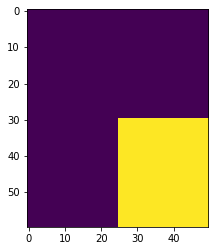

In [ ]:
import numpy as np

def raytrace_triangle(triangle, camera):
    # lhs = torch.stack([-D, B-A, C-A], dim=1)
    # rhs = O - A
    # X = t.linalg.solve(lhs, rhs)
    # s, u, v = [i.item() for i in X]
    # return s >= 0 and u >= 0 and v >= 0 and (u + v) <= 1
    
    # results = []
    # rays = camera.pixel_rays()
    # einops.rearrange(rays, "h w c -> (h w) c")
    # for ray in rays:
    #     does_intersect = triangle_line_intersects(triangle[0], triangle[1], triangle[2], camera.origin, ray)
    #     results.append(1 if does_intersect else 0)
    
    rays = camera.pixel_rays()
    rays = einops.rearrange(rays, "h w c -> (h w) c")
    A, B, C = [point for point in triangle]
    D = rays
    repeat_A = einops.repeat(A, "c -> num_rays c", num_rays=rays.shape[0])
    repeat_B = einops.repeat(B, "c -> num_rays c", num_rays=rays.shape[0])
    repeat_C = einops.repeat(C, "c -> num_rays c", num_rays=rays.shape[0])
    lhs = torch.stack([-D, repeat_B-repeat_A, repeat_C-repeat_A], dim=2)
    repeat_O = einops.repeat(camera.origin, "c -> num_rays c", num_rays=rays.shape[0])
    rhs = repeat_O - repeat_A 
    print(f"lhs: {lhs.shape}")
    print(f"rhs: {rhs.shape}")
    X = t.linalg.solve(lhs, rhs)
    print(f"X.shape: {X.shape}")
    # s, u, v = [i.item() for i in X]
    s = X[:,0]
    u = X[:,1]
    v = X[:,2]
    intersects = torch.logical_and(s >= 0, torch.logical_and(u >= 0, torch.logical_and(v >= 0, (u + v) <= 1)))
    intersects = einops.rearrange(intersects, "(h w) -> h w", h=camera.height, w=camera.width)
    return intersects

camera = Camera()
print(camera.pixel_rays())
# raytrace_result = raytrace_triangle(torch.Tensor([[.5,.3,1],[0,.3,1],[0,0,1]]), camera)
raytrace_result = raytrace_triangle(0.01*torch.Tensor([[1,0,0],[0,1,0],[0,0,1]]), camera)

plt.imshow(raytrace_result)

### Mesh rendering

For raytracing a mesh, we will find the intersection points for all pixel rays and all triangles at once.

In [ ]:
!pip install -q numpy-stl

In [ ]:
!wget -O pikachu-flowalistik.STL -q https://cdn.thingiverse.com/assets/80/10/f0/76/fb/pikachu_1gen_flowalistik.STL

In [ ]:
from stl import mesh
model = mesh.Mesh.from_file('pikachu-flowalistik.STL')
triangles = t.tensor(model.vectors.copy())
triangles[:, :, [2, 0, 1]] = triangles.clone()  # YL: Swapping x/y/z coordinates?

# center the mesh at (0, 0, 0)
mesh_center = triangles.mean(dim=(0, 1))  # YL: Find mean center of triangles
triangles -= mesh_center

Step: implement a function `raytrace_mesh(triangles, camera)` that receives the `triangles` of a mesh (a tensor of size `[T, 3, 3]`) and a `camera` object, and returns a tensor with the distance to the mesh at that pixel (let the distance be infinite if there is no intersection); Use a single batch call to `torch.linalg.solve`. Visualize the result with `plt.imshow`.
* Your function is expected to look similar to `raytrace_triangle`.
* Target the camera towards (0, 0, 0) which is the average position of all triangle vertices due to the centering code in the cell above.

You might end up getting errors like 'the solve could not be completed because the input matrix is singular' on this next part or later if the camera position happens to produce a ray which is parallel to a triangle.
Don't worry about this unless it comes up. You can fix this issue by checking which matrices are singular, replacing these matrices with the identity, and then requiring that the matrix was non-singular for there to be an intersection. (Hint: how can you cheaply check if a matrix is singular?)

torch.Size([60, 50])


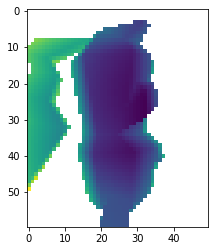

In [ ]:
import numpy as np


def raytrace_mesh(triangles, camera):
    """Return distance from mesh, which is infinity if there's no intersection"""
    # Do over all triangles
    # A is a point of triangle
    A = triangles[:, 0, :]
    B = triangles[:, 1, :]
    C = triangles[:, 2, :]
    O = camera.origin
    
    BA = B-A
    CA = C-A
    OA = O-A
    
    rays = camera.pixel_rays()
    rays = einops.rearrange(rays, "h w c -> (h w) c")
    num_triangles = triangles.shape[0]
    num_rays = rays.shape[0]
    repeated_rays = einops.repeat(rays, "num_rays c -> (num_rays num_triangles) c", num_triangles=num_triangles)
    repeated_BA = einops.repeat(BA, "num_triangles c -> (num_rays num_triangles) c", num_rays = num_rays)
    repeated_CA = einops.repeat(CA, "num_triangles c -> (num_rays num_triangles) c", num_rays = num_rays)
    repeated_OA = einops.repeat(OA, "num_triangles c -> (num_rays num_triangles) c", num_rays = num_rays)
    
    lhs = torch.stack([-repeated_rays, repeated_BA, repeated_CA], dim=2)  # CORRECT?
    rhs = repeated_OA
    X = t.linalg.solve(lhs, rhs)
    X = einops.rearrange(X, "(num_rays num_triangles) c -> num_rays num_triangles c", num_rays=num_rays, num_triangles=num_triangles)
    s = X[:,:,0]
    u = X[:,:,1]
    v = X[:,:,2]
    intersects = torch.logical_and(s >= 0, torch.logical_and(u >= 0, torch.logical_and(v >= 0, (u + v) <= 1)))
    
    # If intersects, we want to take s, otherwise take infinity
    distances = s
    not_intersects = torch.logical_not(intersects)
    distances[not_intersects] = float('inf')
    min_distances = einops.reduce(distances, 'num_rays num_triangles -> num_rays', 'min')
    min_distances = einops.rearrange(min_distances, "(h w) -> h w", h = camera.height, w=camera.width)
    return min_distances
    
    # A, B, C = [point for point in triangle]
    # D = rays
    # repeat_A = einops.repeat(A, "c -> num_rays c", num_rays=rays.shape[0])
    # repeat_B = einops.repeat(B, "c -> num_rays c", num_rays=rays.shape[0])
    # repeat_C = einops.repeat(C, "c -> num_rays c", num_rays=rays.shape[0])
    # lhs = torch.stack([-D, repeat_B-repeat_A, repeat_C-repeat_A], dim=2)
    # repeat_O = einops.repeat(camera.origin, "c -> num_rays c", num_rays=rays.shape[0])
    # rhs = repeat_O - repeat_A 
    # X = t.linalg.solve(lhs, rhs)
    # s = X[:,0]
    # u = X[:,1]
    # v = X[:,2]
    # intersects = torch.logical_and(s >= 0, torch.logical_and(u >= 0, torch.logical_and(v >= 0, (u + v) <= 1)))
    # intersects = einops.rearrange(intersects, "(h w) -> h w", h=camera.height, w=camera.width)
    # return intersects


camera = Camera(origin=60*torch.Tensor([0,0,1]), target=torch.Tensor([0,0,0]))
raytrace_mesh(triangles, camera)
raytrace_result = raytrace_mesh(triangles, camera)
print(raytrace_result.shape)
plt.imshow(raytrace_result)


In [ ]:
torch.Tensor([1., 3]) - torch.Tensor([2])

tensor([-1.,  1.])

### Vectorizing it further

In [ ]:
!pip install -q mediapy

In [ ]:
from PIL import Image
import mediapy as media

We can just keep vectorizing! We will now make a video rotating around our model mesh.

Write a function `multirender_mesh(triangles, camera, origins)`, behaving similar to `render_mesh`, with the change that it accepts a parameter `origins`, corresponding to different positions of the camera, and returns the distances to the model for each origin and pixel. Use a single call to `torch.linalg.solve`. Use this function to make a video rotating around the model. You can use [media.show_video](https://google.github.io/mediapy/#mediapy.show_video) to display the video in a notebook. The easiest way to do this is probably to render each frame with matplotlib to an image file, load each image file using `Image`, and then pass all the images to `media.show_video`. 

This might end up taking a while to run. Be careful not to use too much RAM! 

_Optional: run the rendering on the GPU and try to make it faster. Also consider playing around with other meshes._

In [ ]:
def multirender_mesh(triangles, camera, origins):
    A = triangles[:, 0, :]
    B = triangles[:, 1, :]
    C = triangles[:, 2, :]
    
    BA = B-A
    CA = C-A

    num_origins = origins.shape[0]
    num_triangles = triangles.shape[0]
    repeated_A = einops.repeat(A, "num_triangles c -> num_origins num_triangles c", num_origins=num_origins)
    repeated_o = einops.repeat(origins, "num_origins c -> num_origins num_triangles c", num_triangles=num_triangles)
    OA = repeated_o-repeated_A
    
    rays = torch.stack([Camera(origin=origin, target=torch.Tensor([0,0,0]), height=camera.height, width=camera.width).pixel_rays() for origin in origins])
    print(rays.shape)
    rays = einops.rearrange(rays, "o h w c -> o (h w) c")
    num_rays = rays.shape[1]
    repeated_rays = einops.repeat(rays, "num_origins num_rays c -> num_origins (num_rays num_triangles) c", num_triangles=num_triangles)
    repeated_BA = einops.repeat(BA, "num_triangles c -> num_origins (num_rays num_triangles) c", num_origins=num_origins, num_rays=num_rays)
    repeated_CA = einops.repeat(CA, "num_triangles c -> num_origins (num_rays num_triangles) c", num_origins=num_origins, num_rays=num_rays)
    repeated_OA = einops.repeat(OA, "num_origins num_triangles c -> num_origins (num_rays num_triangles) c", num_rays=num_rays)
    print(rays.shape, BA.shape, OA.shape)
    print(repeated_rays.shape, repeated_BA.shape, repeated_OA.shape)
    lhs = torch.stack([-repeated_rays, repeated_BA, repeated_CA], dim=3)
    rhs = repeated_OA
    # A shape something*n*n, B shape something*n
    X = t.linalg.solve(lhs, rhs) # num_origins x (num_rays * num_triangles) x 3
    X = einops.rearrange(X, "num_origins (num_rays num_triangles) c -> num_origins num_rays num_triangles c", num_rays=num_rays, num_triangles=num_triangles)
    s = X[:,:,:,0]
    u = X[:,:,:,1]
    v = X[:,:,:,2]
    intersects = torch.logical_and(s >= 0, torch.logical_and(u >= 0, torch.logical_and(v >= 0, (u + v) <= 1)))
    
    # If intersects, we want to take s, otherwise take infinity
    distances = s
    not_intersects = torch.logical_not(intersects)
    distances[not_intersects] = float('inf')
    min_distances = einops.reduce(distances, 'num_origins num_rays num_triangles -> num_origins num_rays', 'min')
    min_distances = einops.rearrange(min_distances, "num_origins (h w) -> num_origins h w", h = camera.height, w=camera.width)
    return min_distances

# origins = torch.Tensor([[x/10, 1, 1] for x in range(3,10)])
# origins = torch.stack([60*x*torch.Tensor([.01236821,0.01287395,1.0218396]) for x in range(1,4)])

origins = torch.stack([60*x*torch.Tensor([0,0,1]) for x in range(1,4)])
camera = Camera(origin=60*torch.Tensor([0,0,1]), target=torch.Tensor([0,0,0]))
raytrace_result = multirender_mesh(triangles, camera, origins)
# images = einops.repeat(raytrace_result, "a b c -> a b c rgb", rgb=3)

In [ ]:
images = []

from PIL import Image

print(raytrace_result.shape)
for i, frame in enumerate(raytrace_result):
    fname = f"frame-{i}.png"
    plt.imsave(fname, frame)
    with Image.open(fname) as im:
        images.append(np.asarray(im)[:,:,:3])
print(images[0].shape)
media.show_video(images, fps=5)
# media.show_video(images.numpy())

torch.Size([3, 60, 50])
(60, 50, 3)


"<source src=""data:video/mp4;base64,AAAAIGZ0eXBpc29tAAACAGlzb21pc28yYXZjMW1wNDEAAAAIZnJlZQAABxttZGF0AAACfgYF//963EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE1NSByMjkxNyAwYTg0ZDk4IC0gSC4yNjQvTVBFRy00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAxOCAtIGh0dHA6Ly93d3cudmlkZW9sYW4ub3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFseXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVkX3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBkZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTIgbG9va2FoZWFkX3RocmVhZHM9MSBzbGljZWRfdGhyZWFkcz0wIG5yPTAgZGVjaW1hdGU9MSBpbnRlcmxhY2VkPTAgYmx1cmF5X2NvbXBhdD0wIGNvbnN0cmFpbmVkX2ludHJhPTAgYmZyYW1lcz0zIGJfcHlyYW1pZD0yIGJfYWRhcHQ9MSBiX2JpYXM9MCBkaXJlY3Q9MSB3ZWlnaHRiPTEgb3Blbl9nb3A9MCB3ZWlnaHRwPTIga2V5aW50PTI1MCBrZXlpbnRfbWluPTUgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVzaD0wIHJjPWNxcCBtYnRyZWU9MCBxcD0yMCBpcF9yYXRpbz0xLjQwIHBiX3JhdGlvPTEuMzAgYXE9MACAAAACeGWIhAD/sctgkjX4DXNKu9cYOzgfh0V9SBj0hWeyLcd+0xapHOsMysz8g1qGLJIFbcM9DH+coZI7R9ReD7EtsMklsmEylp9Mh8pp8HLQWiRDk+qJQCSx4SlHo9hSlecffepw2AsCn5lzMZSv/Ds3z0JDZwwZZumLgHUXS+G4SZVVCjGXcdB2RWGPj84cgT2YgZ6qUoYuAqFMEnw91jpaWsZvHJbKigy5IPYS63zezXbAUKc2aFh5Tyjb71JeLNGJ2QJ3r90OPW/P7q0uywln/v2maIpqmmZ0EOHH3WnUOMbLtiGapwRt7X1+vHFZloeBf5s/LrhKIlFjIfQaUlDrImj5xb2aYgM15AbgOqwvVQLDsDHjRQbJXa2gpO8b96xhCiw+i9NiCC62/MyU4GbwiyBwzL/OrrGFEyN5pf8aq8uwuGl+6sd39MPf/ePBz1JIWwWxJDY5FotSt+EMSuZtyH9lObW0P03NQwY2TW0/O1FDKzRbw2xQ1dmndkO23FQgYMGaktb99BSnzT9alfOCFxplXSHvwom7319YLY9USskV1/ipYoVme7VXWXhHOWs2nrd8fpnv+aHAGY85zz+OpDIfslHQJLM2QN5h1PKgws5WKIVb4OenKbEX8MfzRd2FpChfBMPpOS7RvtgiMo9h14E+8/KY5Zitw7UzKEO+0HyVOPJAJwAM24gBZtLOeJASkDdVEpyZP/B01U5B+GqVAEGx20m2HPHIkDSF+KR7FZUGCPPfetA7tiyOgoPjotuwN3H0XSWl+Y54t5RsIwwQVQ3YJJBtkRarftodAFi9CQIzqPJzdTRHP3NG7y3AmcyTxRfpmyo7/mpPAAABdEGIiEP//vSg+BTQYmPKzFa4T9GGFi/mBsOTY5097hcS6rVOj20RFdMEa7BT3W4qP6B5dCHDdhbNEP9TXaJNvPUs8co3Edw9HA5z8ndxs2eLiBKgPZ9ywGl2qkCpVaUrej9BV1RmxU0MvXnnutAN6z6GoCIEGMihwMuxcjc5NZTCwjd7f7Lg/0TCaLDzohEPpjjSbCfblEn5c8O3qojeFpopd+bvCfBK2NkrSOk8gytl4uZP2lQ5WutNhH9kt6rmqZwuawF76AliIYCdRSnAPHG3ViL72PU9e55vFyuvOww7zkIN9deJHP3w4Tvk06zfidg9v5CIj9N1QtfxTBMBJyeJkf62pr97CClZeqqXIBr0u41eHx51vTz4ENun9dlmPElsPW4oiPsCSMmm+8s5CXHxug8hAm1Rh9lWNQ1q32lbG8tHmcEac7JtFRmymE4t2yUw5Z0xJHs3dwohYWqRj2NUgRw9AApsF8AjY4DyPJgSko3gsAAAAJlBmkJJ4QhDIIEQFUKgKYC0AqgK0BVCAP/uSqCoWXayGDB2b/LWSeef/tXy2OpspAHU8fVtQC7QnHW1wPdt9VwCP5oj/PLLl2HfVDfwMeCMC1DcN4cq/VbKsx+RLPZVeiqx1ATuzerbvZ4T2YJzuANQmGr8DpVYLK4Rn8lgv4AFG/KCqgFDKvccr2IyMQL70v/PRkHJly4FlH0AAAMnbW9vdgAAAGxtdmhkAAAAAAAAAAAAAAAAAAAD6AAAAlgAAQAAAQAAAAAAAAAAAAAAAAEAAAAAAAAAAAAAAAAAAAABAAAAAAAAAAAAAAAAAABAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAgAAAlF0cmFrAAAAXHRraGQAAAADAAAAAAAAAAAAAAABAAAAAAAAAlgAAAAAAAAAAAAAAAAAAAAAAAEAAAAAAAAAAAAAAAAAAAABAAAAAAAAAAAAAAAAAABAAAAAADIAAAA8AAAAAAAkZWR0cwAAABxlbHN0AAAAAAAAAAEAAAJYAAAQAAABAAAAAAHJbWRpYQAAACBtZGhkAAAAAAAAAAAAAAAAAAAoAAAAGABVxAAAAAAALWhkbHIAAAAAAAAAAHZpZGUAAAAAAAAAAAAAAABWaWRlb0hhbmRsZXIAAAABdG1pbmYAAAAUdm1oZAAAAAEAAAAAAAAAAAAAACRkaW5mAAAAHGRyZWYAAAAAAAAAAQAAAAx1cmwgAAAAAQAAATRzdGJsAAAAmHN0c2QAAAAAAAAAAQAAAIhhdmMxAAAAAAAAAAEAAAAAAAAAAAAAAAAAAAAAADIAPABIAAAASAAAAAAAAAABAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGP//AAAAMmF2Y0MBZAAK/+EAGWdkAAqs2UQniLhAAAADAEAAAAMCg8SJZYABAAZo6+GyyLAAAAAYc3R0cwAAAAAAAAABAAAAAwAACAAAAAAUc3RzcwAAAAAAAAABAAAAAQAAABhjdHRzAAAAAAAAAAEAAAADAAAQAAAAABxzdHNjAAAAAAAAAAEAAAABAAAAAwAAAAEAAAAgc3RzegAAAAAAAAAAAAAAAwAABP4AAAF4AAAAnQAAABRzdGNvAAAAAAAAAAEAAAAwAAAAYnVkdGEAAABabWV0YQAAAAAAAAAhaGRscgAAAAAAAAAAbWRpcmFwcGwAAAAAAAAAAAAAAAAtaWxzdAAAACWpdG9vAAAAHWRhdGEAAAABAAAAAExhdmY1OC4yOS4xMDA="" type=""video/mp4""/> This browser does not support the video tag."


[print(image.shape) for image in images]

In [ ]:
[print(image.shape) for image in images]

(60, 50, 4)
(60, 50, 4)
(60, 50, 4)


NameError: name 'k' is not defined

### Optional extensions

1. Allow for triangles to have RGB values and render a colored image.
2. We've been using a single ray to sample the scene and determine the color of a pixel. This can result in the image having pixelated boundaries. Really, a pixel is a 2d square subsection of the overall image and should consist of the average ray color over this subsection: 

![image.png](attachment:image.png)


Allow for randomly sampling some number of rays for each pixel. Alternatively, subsample some number of rays per pixel in a grid.


3. Instead of uniformly illuminating each triangle, allow for specifying a few point light source and use the [Phong reflection model (BRDF)](https://en.wikipedia.org/wiki/Phong_reflection_model) for illumination (ignore shadows). Note that this is conceptually more complex and requires thinking about concepts we haven't covered here!